In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/trainv3.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev3/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev3/val.feather')

In [5]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 236 ms, sys: 56.1 ms, total: 292 ms
Wall time: 291 ms


In [6]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

In [7]:
traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]


FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday']

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type    0
send_day              0
send_hour             0
send_weekday          0
dtype: int64

Test nulls:
communication_type    0
send_day              0
send_hour             0
send_weekday          0
dtype: int64


** Train and Validate **

In [10]:
m = RandomForestClassifier(n_estimators=10, max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
val_preds = m.predict_proba(X_val)[:, 1]
print('AUC score: {}'.format(roc_auc_score(y_val, val_preds)))

AUC score: 0.5580286315642277


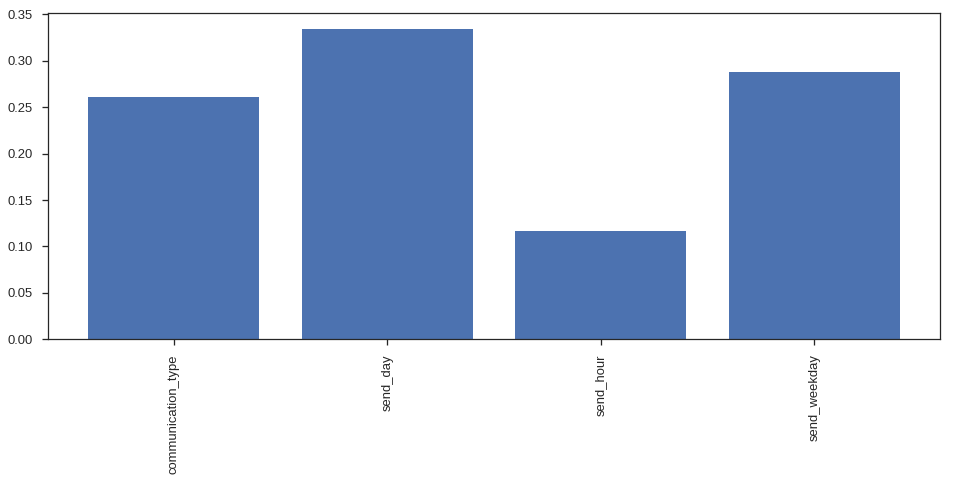

In [11]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(FEATURES)), m.feature_importances_)
plt.xticks(np.arange(len(FEATURES)), FEATURES, rotation=90);

** Full Training **

In [8]:
%%time

m = RandomForestClassifier(max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
preds = m.predict_proba(X_val)[:, 1]

CPU times: user 5.64 s, sys: 125 ms, total: 5.77 s
Wall time: 2.2 s


** Submission **

In [9]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission5.csv', index=False)